# Image Augmentation and Preprocessing Utilities
This notebook provides utility functions for image preprocessing and augmentation commonly used in deep learning tasks.

#

In [2]:
# Import necessary libraries
import os
import io
import numpy as np
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt
from tqdm import tqdm

## Image Loading and Preprocessing

#

In [3]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess an image.

    Args:
        image_path (str): Path to the image file
        target_size (tuple): Desired output size (width, height)

    Returns:
        PIL.Image: Preprocessed image
    """
    # Load image
    img = Image.open(image_path)

    # Convert to RGB if necessary
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Resize image
    img = img.resize(target_size, Image.Resampling.LANCZOS)

    return img

def load_images_from_directory(directory_path, target_size=(224, 224)):
    """
    Load all images from a directory and preprocess them.

    Args:
        directory_path (str): Path to the directory containing images
        target_size (tuple): Desired output size (width, height)

    Returns:
        list: List of preprocessed images
    """
    images = []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}

    for filename in tqdm(os.listdir(directory_path)):
        if os.path.splitext(filename)[1].lower() in valid_extensions:
            image_path = os.path.join(directory_path, filename)
            try:
                img = load_and_preprocess_image(image_path, target_size)
                images.append(img)
            except Exception as e:
                print(f"Error loading {filename}: {str(e)}")

    return images

## Image Augmentation Functions

In [4]:
class BasicAugmenter:
    def __init__(self, p=0.5):
        """
        Initialize the augmentation pipeline.

        Args:
            p (float): Probability of applying each augmentation
        """
        self.transform = A.Compose([
            A.HorizontalFlip(p=p),
            A.RandomRotate90(p=p),
            A.VerticalFlip(p=p),
            A.RandomBrightnessContrast(p=p),
            A.RandomCrop(height=178, width=178, p=p),
            A.HueSaturationValue(p=p),
            A.GaussNoise(p=p)
        ])

    def augment(self, image):
        """
        Apply augmentations to an image.

        Args:
            image (PIL.Image): Input image

        Returns:
            PIL.Image: Augmented image
        """
        # Convert PIL image to numpy array
        image_np = np.array(image)

        # Apply augmentations
        augmented = self.transform(image=image_np)['image']

        # Convert back to PIL image
        return Image.fromarray(augmented)

## Display Function

In [9]:
def display_augmentations(image, n_examples=5):
    """
    Display original image and multiple augmented versions.

    Args:
        image (PIL.Image): Input image
        n_examples (int): Number of augmented examples to show
    """
    augmenter = BasicAugmenter(p=0.5)

    plt.figure(figsize=(15, 3))

    # Display original image
    plt.subplot(1, n_examples + 1, 1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')

    # Display augmented versions
    for i in range(n_examples):
        augmented_image = augmenter.augment(image)
        plt.subplot(1, n_examples + 1, i + 2)
        plt.imshow(augmented_image)
        plt.title(f'Augmented {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Testing: Load and augment a single image
To use this code, replace 'path_to_your_image.jpg' with the path to the image and replace image_path variable with the image directory.

#

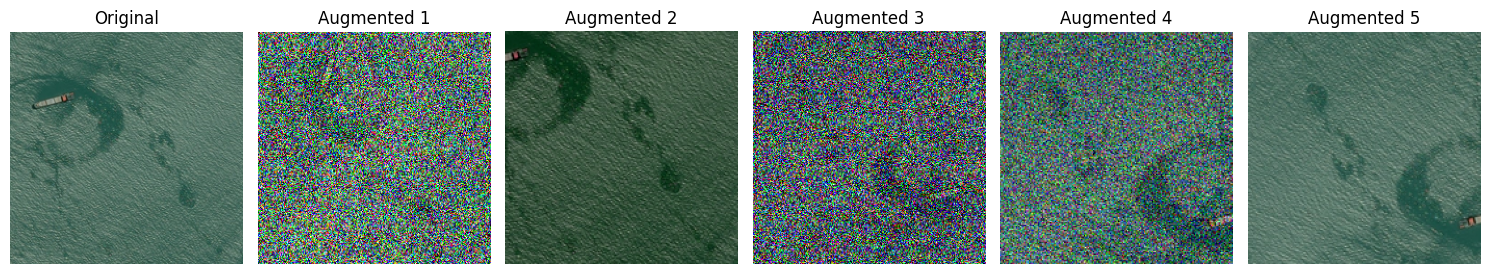

100%|██████████| 3436/3436 [00:43<00:00, 79.46it/s]


In [19]:
# Load and preprocess a single image
image = load_and_preprocess_image('E:/Datasets/MasatiV2/JPEGImages/7bd3a77f3.bmp')
directory_path = 'E:/Datasets/MasatiV2/JPEGImages/'

# Display original and augmented versions
display_augmentations(image)

# Load multiple images from a directory
images = load_images_from_directory(directory_path)


## Calculating Dataset Size

In [17]:
def calculate_augmented_dataset_size(n_original_images, augmentations_per_image=5,
                                     original_image_size_mb=None, sample_image=None):
    """
    Calculate the approximate dataset size after augmentation.

    Args:
        n_original_images (int): Number of images in original dataset
        augmentations_per_image (int): Number of augmented versions per original image
        original_image_size_mb (float, optional): Average size of one image in MB
        sample_image (PIL.Image, optional): Sample image to calculate average size

    Returns:
        dict: Dictionary containing:
            - total_images: Total number of images after augmentation
            - original_size_mb: Approximate size of original dataset in MB
            - augmented_size_mb: Approximate size of augmented dataset in MB
    """
    # Calculate total number of images after augmentation
    total_images = n_original_images * (augmentations_per_image + 1)  # +1 for original images

    # If image size not provided, try to calculate from sample image
    if original_image_size_mb is None and sample_image is not None:
        # Convert PIL image to bytes and calculate size in MB
        with io.BytesIO() as bio:
            sample_image.save(bio, format='BMP')
            original_image_size_mb = len(bio.getvalue()) / (1024 * 1024)

    # Calculate sizes if we have image size information
    if original_image_size_mb is not None:
        original_size_mb = n_original_images * original_image_size_mb
        augmented_size_mb = total_images * original_image_size_mb
    else:
        original_size_mb = None
        augmented_size_mb = None

    return {
        'total_images': total_images,
        'original_size_mb': original_size_mb,
        'augmented_size_mb': augmented_size_mb
    }

In [18]:
# With a sample image
result = calculate_augmented_dataset_size(
    n_original_images=len(images),
    augmentations_per_image=5,
    sample_image=image  # Using the loaded image
)

print(f"Total images after augmentation: {result['total_images']}")
print(f"Original dataset size: {result['original_size_mb']:.2f} MB")
print(f"Augmented dataset size: {result['augmented_size_mb']:.2f} MB")


Total images after augmentation: 20616
Original dataset size: 493.43 MB
Augmented dataset size: 2960.59 MB
